In [44]:
%config InlineBackend.figure_format='retina'
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colormaps as cm
import itertools
from tqdm.notebook import tqdm
from glob import glob
from scipy.stats import norm
from scipy.special import softmax
from datetime import datetime, time

from model import baseline
from model.helpers import square_exponential_kernel, normalize_last_dim
from plot import plot
from data.data_path import data_path

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process.kernels import WhiteKernel, RBF, ConstantKernel, Matern, RationalQuadratic
from sklearn.gaussian_process import GaussianProcessRegressor

# from model.ball_base_model import *

from sklearn.mixture import GaussianMixture
import numpy as np
import matplotlib.pyplot as plt
from scripts.compute_transition_matrices import plot_transition_matrix

In [76]:
def load_data(u):

    file = glob(f"{data_path}/dump_latest/{u}_activity*.csv")[0]

    df = pd.read_csv(file, index_col=0)
    df.dt = pd.to_datetime(df.dt, utc=False, format="ISO8601")
    df.dt = df.dt.dt.tz_convert("Europe/London")

    all_pos = df.step_midnight.values

    min_date = df.dt.min().date()
    days = np.asarray([(dt.date() - min_date).days for dt in df.dt])
    uniq_days = np.unique(days)
    all_timestamp = (
        np.asarray(
            [
                (dt - datetime.combine(dt, time.min, dt.tz)).total_seconds()
                for dt in df.dt
            ]
        )
        / 86400
    )  # in fraction of day (between 0 and 1)

    # List of step events for each day, the event itself being the timestamp of the step
    step_events = [[] for _ in range(uniq_days.size)]

    for idx_day, day in enumerate(uniq_days):
        is_day = days == day
        obs_timestamp, obs_pos = all_timestamp[is_day], all_pos[is_day]

        # Sort the data by timestamp
        idx = np.argsort(obs_timestamp)
        obs_timestamp, obs_pos = obs_timestamp[idx], obs_pos[idx]

        # Compute the number of steps between each observed timestamp
        diff_obs_pos = np.diff(obs_pos)

        for ts, dif in zip(obs_timestamp, diff_obs_pos):
            # TODO: In the future, we probably want to spread that
            #  over a period assuming something like 6000 steps per hour
            step_events[idx_day] += [ts for _ in range(dif)]

    return step_events

In [77]:
user = "11AV"  # Select the user to use
bkp_folder = f"../../bkp/compute_transition_matrices/{user}*"

# Load data
step_events = load_data(user)
print("n_days raw", len(step_events))
step_events = [i for i in step_events if len(i)]
n_days = len(step_events)
print("n_days after filtering empty days", len(step_events))

n_days raw 18
n_days after filtering empty days 17


In [79]:
from scipy.special import logit
from scipy.special import expit as sigmoid

In [80]:
# jitter = np.finfo(np.float64).tiny

# Define the range of number of components to try
n_components_range = range(1, 11)
cmp_score = np.zeros((n_days, len(list(n_components_range))))

for day in range(n_days):
    print(f"Day {day}", len(step_events[day]), "steps")
    X = logit(np.asarray(step_events[day]).reshape(-1, 1))
    # List to hold the BIC for each number of components
    
    # Fit a Gaussian Mixture Model for each number of components
    for i, n_components in enumerate(n_components_range):
        gmm = GaussianMixture(n_components=n_components)
        gmm.fit(X)
        cmp_score[day, i] = gmm.aic(X)

Day 0 1465 steps
Day 1 3112 steps
Day 2 808 steps
Day 3 1584 steps
Day 4 2247 steps
Day 5 7052 steps
Day 6 7080 steps
Day 7 2218 steps
Day 8 7013 steps
Day 9 7675 steps
Day 10 2820 steps
Day 11 3012 steps
Day 12 7011 steps
Day 13 64 steps
Day 14 7179 steps
Day 15 2561 steps
Day 16 3717 steps


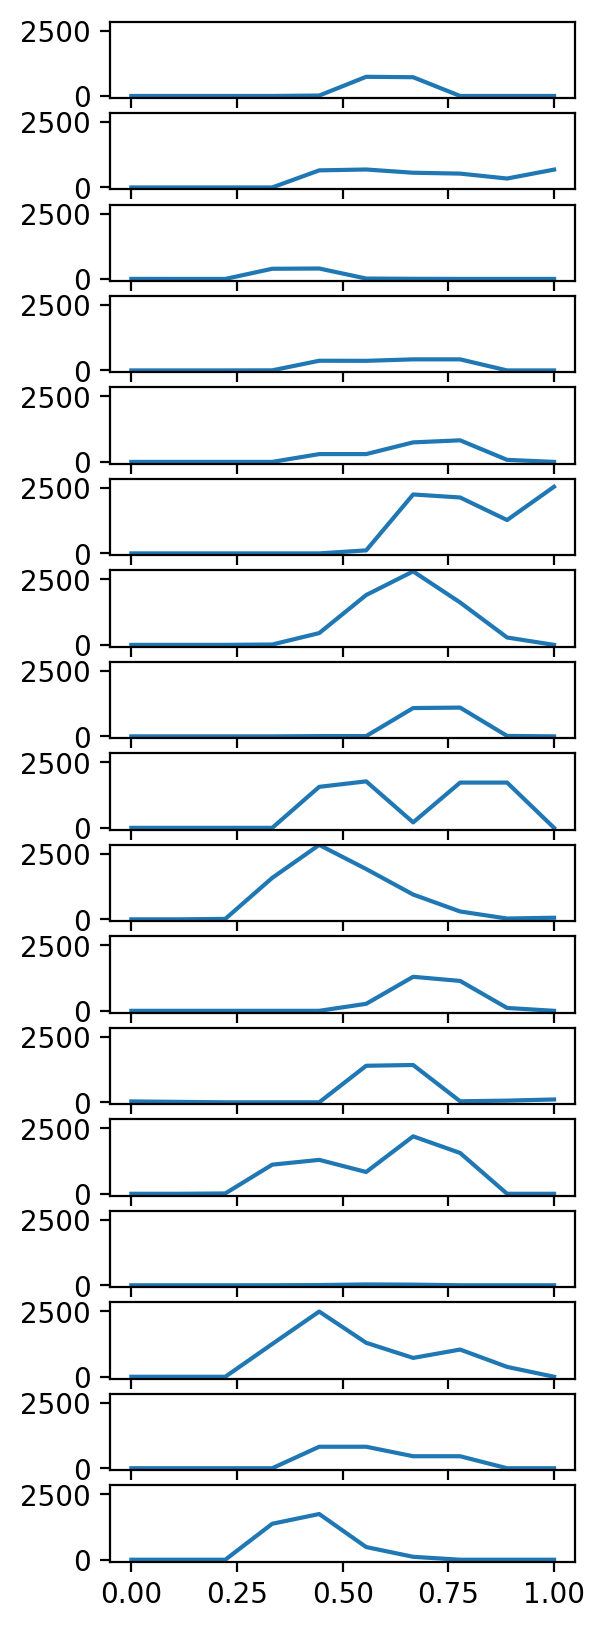

In [81]:
n_timestep = 10
timestep = np.linspace(0, 1, n_timestep)
X_train = []
y_train = []
deriv_cum_steps = np.zeros((n_days, timestep.size))
for idx_day in range(n_days):
    cum_steps_day = np.sum(step_events[idx_day] <= timestep[:, None], axis=1)
    deriv_cum_steps_day =  np.gradient(cum_steps_day, timestep+1) / (timestep.size-1)
    deriv_cum_steps[idx_day] = deriv_cum_steps_day
    # print(np.sum(deriv_cum_steps_day))
    X_train.append(list(timestep))
    y_train.append(list(deriv_cum_steps_day))


fig, axes = plt.subplots(deriv_cum_steps.shape[0], figsize=(3, 10), sharex=True)
for ax, activity in zip(axes, deriv_cum_steps):
    ax.plot(timestep, activity, color="C0")
    ax.set_ylim(-70, np.max(deriv_cum_steps))
    ax.grid(False)

In [82]:
len(list(n_components_range))

10

n days 17


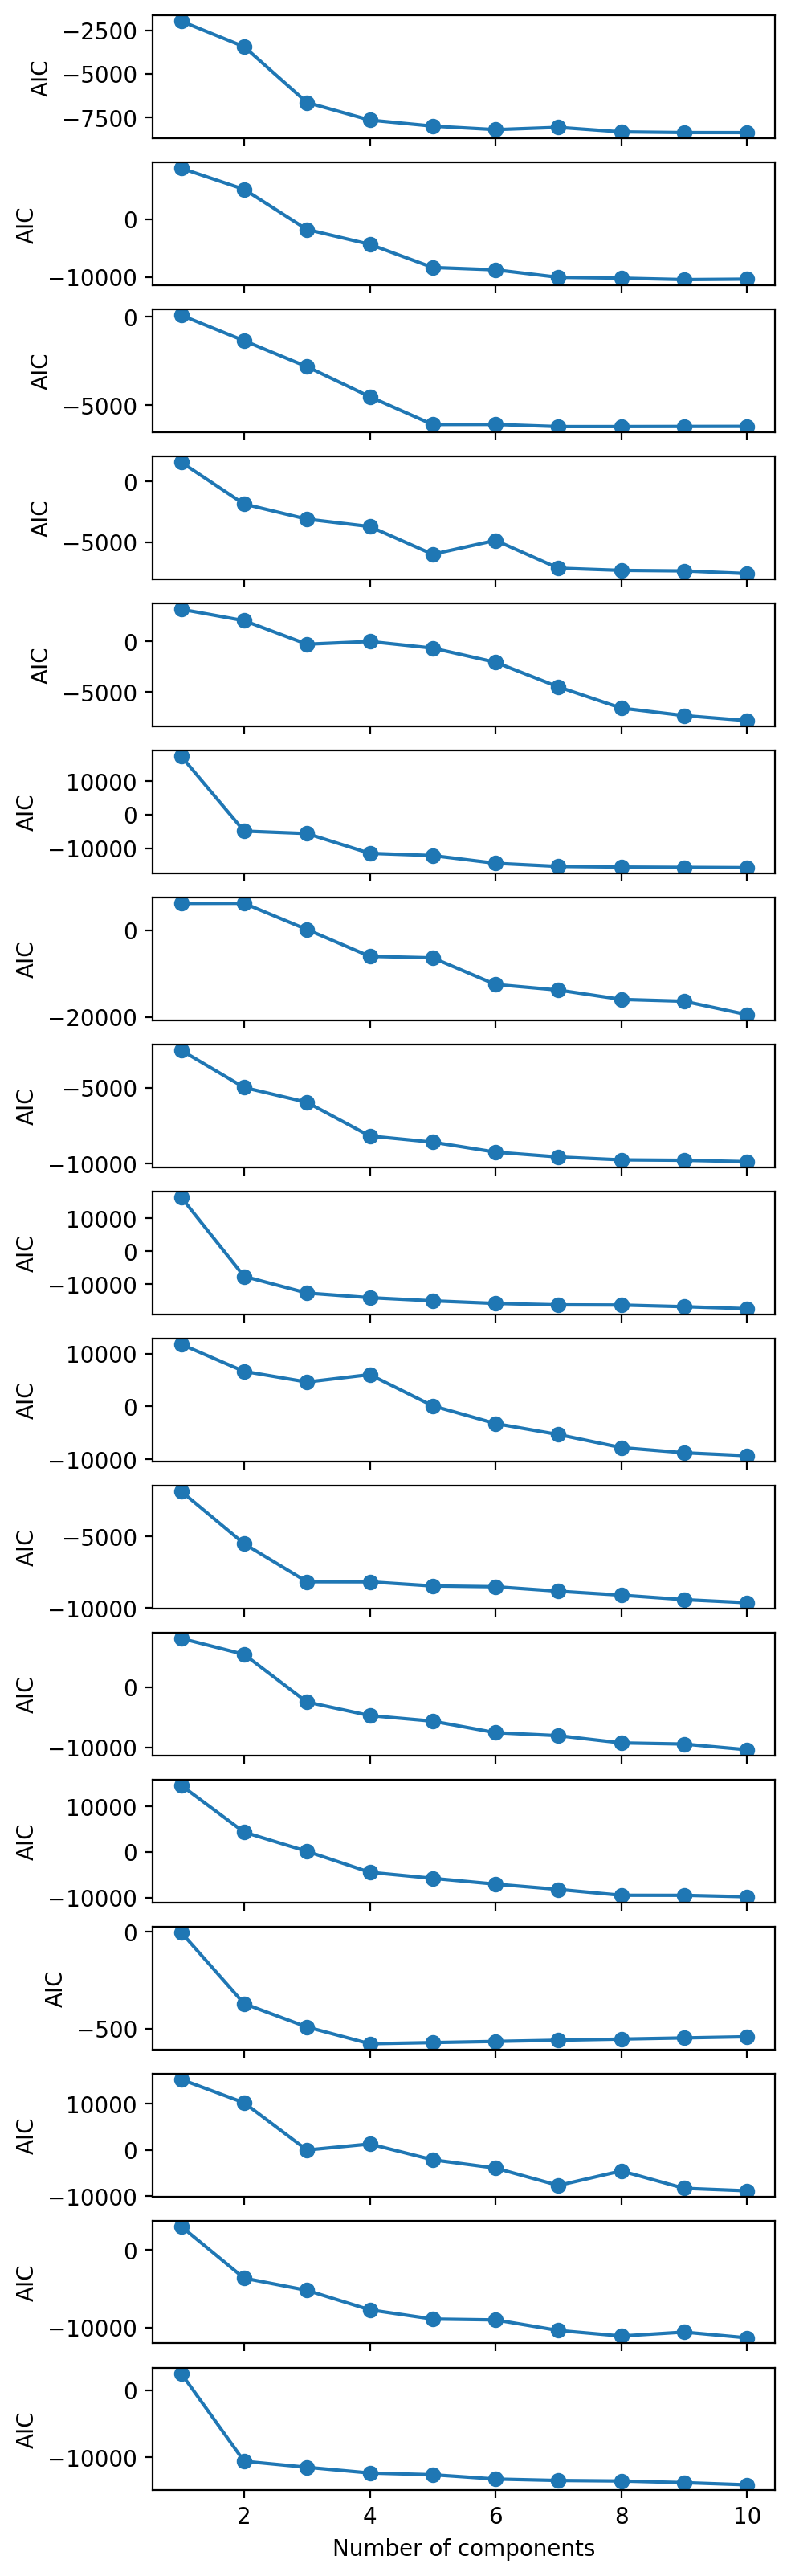

In [83]:
fig, axes = plt.subplots(nrows=n_days, figsize=(5, 20), sharex=True)
print("n days", n_days)
for day in range(n_days):
    ax = axes[day]
    ax.plot(n_components_range, cmp_score[day], marker='o')
    if day == n_days-1:(
        ax.set_xlabel('Number of components'))
    ax.set_ylabel('AIC')

In [94]:
param = np.zeros((n_days, 3)) # mu, sigma, n

# Define the range of number of components to try
n_components_range = range(1, 11)
cmp_score = np.zeros((n_days, len(list(n_components_range))))

max_n = max([len(step_events[day]) for day in range(n_days)])

for day in range(n_days):
    X = np.asarray(step_events[day])
    param[day] = logit(X.mean()), np.log(X.std()), np.exp(X.size/max_n)

In [95]:
gmm = GaussianMixture(n_components=1)
gmm.fit(param)
print("Means:", gmm.means_)
print("Covariances:", gmm.covariances_)

Means: [[ 0.45103159 -2.51574731  1.76193222]]
Covariances: [[[0.16647998 0.03108194 0.03242622]
  [0.03108194 0.37595569 0.23042733]
  [0.03242622 0.23042733 0.35684444]]]


In [96]:
n_samples = 5
samples, _ = gmm.sample(n_samples)

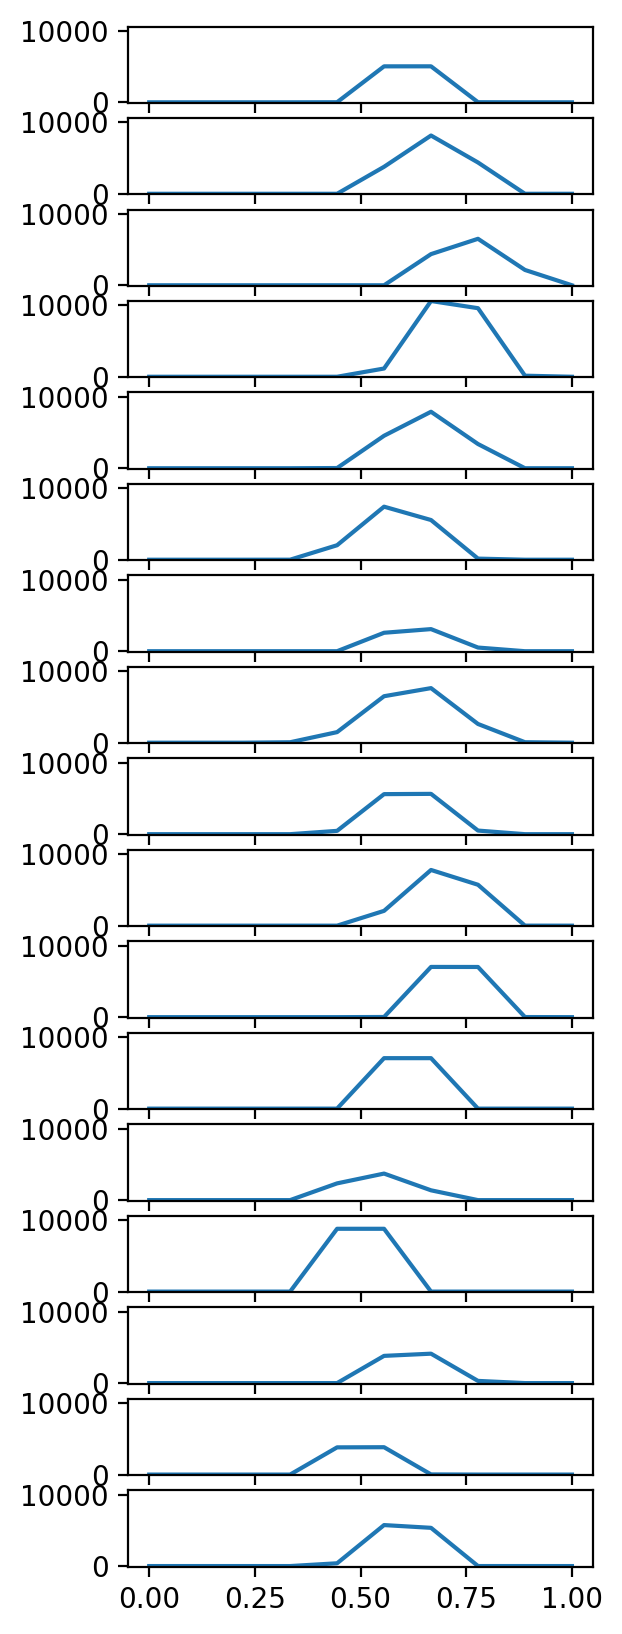

In [98]:
n_timestep = 10
timestep = np.linspace(0, 1, n_timestep)
X_train = []
y_train = []
deriv_cum_steps = np.zeros((n_days, timestep.size))
for idx_day in range(n_days):
    samples, _ = gmm.sample(1)
    smp = samples[0]
    mu = smp[0]
    sigma = np.exp(smp[1])
    n = smp[2]*max_n
    
    draws = np.random.normal(mu, sigma, size=int(n))
    
    step_events_day = sigmoid(draws)
    
    cum_steps_day = np.sum(step_events_day <= timestep[:, None], axis=1)
    deriv_cum_steps_day =  np.gradient(cum_steps_day, timestep+1) / (timestep.size-1)
    deriv_cum_steps[idx_day] = deriv_cum_steps_day
    # print(np.sum(deriv_cum_steps_day))
    X_train.append(list(timestep))
    y_train.append(list(deriv_cum_steps_day))


fig, axes = plt.subplots(deriv_cum_steps.shape[0], figsize=(3, 10), sharex=True)
for ax, activity in zip(axes, deriv_cum_steps):
    ax.plot(timestep, activity, color="C0")
    ax.set_ylim(-70, np.max(deriv_cum_steps))
    ax.grid(False)